In [1]:
import os
import sys
from pathlib import Path

import pkg_resources

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
# Force reinstall/upgrade transformer_lens to ensure latest compatible version
%pip install --upgrade transformer_lens einops eindex-callum jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/ARENA_3.0-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

/tmp/ipython-input-4123038804.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-wg2bzw84
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-wg2bzw84
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import functools
import sys
from pathlib import Path
from typing import Callable

import circuitsvis as cv
import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from eindex import eindex
from IPython.display import display
from jaxtyping import Float, Int
from torch import Tensor
from tqdm import tqdm
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)
from transformer_lens.hook_points import HookPoint

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part2_intro_to_mech_interp"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

import part2_intro_to_mech_interp.tests as tests
from plotly_utils import (
    hist,
    imshow,
    plot_comp_scores,
    plot_logit_attribution,
    plot_loss_difference,
)

# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

MAIN = __name__ == "__main__"


In [3]:
# for the first experiment im going to use gpt2-xl
device = "cuda" if t.cuda.is_available() else "cpu"
# If you encounter an OutOfMemoryError, try running on CPU or using a smaller model like 'gpt2'
model = HookedTransformer.from_pretrained("gpt2-xl").to(device)
print(model.cfg)


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda
HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'NTK_original_ctx_len': 8192,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 6400,
 'd_model': 1600,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'cuda',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02,
 'load_in_4bit': False,
 'model_name': 'gpt2-xl',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 25,
 'n_key_value_heads': None,
 'n_layers':

In [58]:
numbers = [f" {i}" for i in range(1, 101)]
# tokenized = [model.to_str_tokens(n) for n in numbers]

# for n, toks in zip(numbers, tokenized):
#     print(n, "→", toks)

# The error `IndexError: too many indices for tensor of dimension 2` occurs because `cache['resid_post', layer]` is a 2-dimensional tensor,
# but the code attempts to index it with three dimensions `[:, number_pos, :]`.
# This can happen if `remove_batch_dim=True` implicitly flattens the batch and sequence dimensions.
# To fix this, we set `remove_batch_dim=False` (which is also the default).
# This ensures `cache['resid_post', layer]` always has 3 dimensions: `[batch_size, sequence_length, d_model]`,
# making the indexing `[:, number_pos, :]` valid.
logits, cache = model.run_with_cache(numbers, remove_batch_dim=False)
num_layers = model.cfg.n_layers

number_pos = 1
embeddings = []
for layer in range(num_layers):
    emb = cache['resid_post', layer][:, number_pos, :]
    embeddings.append(emb)

embeddings = t.stack(embeddings)
print(embeddings.shape)
print(embeddings[:1]) #embedded numbers from 1-100 and the residual stream here is composed of attention head outpurs and MLP outputs


torch.Size([48, 100, 1600])
tensor([[[-0.3433,  0.7334, -0.2215,  ..., -0.6734,  0.0229, -0.6794],
         [-0.2147,  0.8726, -0.5121,  ..., -0.3999,  0.1474, -0.1236],
         [-0.0793,  0.6393,  0.0800,  ..., -0.3033, -0.0049, -0.4062],
         ...,
         [-0.2060,  0.7062, -0.4170,  ...,  0.5073, -0.8208,  0.1590],
         [ 0.0938,  0.6716, -0.1336,  ...,  0.2343, -0.7062, -0.1790],
         [ 0.1671,  0.6806,  0.1280,  ...,  0.3937, -0.2275, -0.6007]]],
       device='cuda:0')


In [59]:
numbers


[' 1',
 ' 2',
 ' 3',
 ' 4',
 ' 5',
 ' 6',
 ' 7',
 ' 8',
 ' 9',
 ' 10',
 ' 11',
 ' 12',
 ' 13',
 ' 14',
 ' 15',
 ' 16',
 ' 17',
 ' 18',
 ' 19',
 ' 20',
 ' 21',
 ' 22',
 ' 23',
 ' 24',
 ' 25',
 ' 26',
 ' 27',
 ' 28',
 ' 29',
 ' 30',
 ' 31',
 ' 32',
 ' 33',
 ' 34',
 ' 35',
 ' 36',
 ' 37',
 ' 38',
 ' 39',
 ' 40',
 ' 41',
 ' 42',
 ' 43',
 ' 44',
 ' 45',
 ' 46',
 ' 47',
 ' 48',
 ' 49',
 ' 50',
 ' 51',
 ' 52',
 ' 53',
 ' 54',
 ' 55',
 ' 56',
 ' 57',
 ' 58',
 ' 59',
 ' 60',
 ' 61',
 ' 62',
 ' 63',
 ' 64',
 ' 65',
 ' 66',
 ' 67',
 ' 68',
 ' 69',
 ' 70',
 ' 71',
 ' 72',
 ' 73',
 ' 74',
 ' 75',
 ' 76',
 ' 77',
 ' 78',
 ' 79',
 ' 80',
 ' 81',
 ' 82',
 ' 83',
 ' 84',
 ' 85',
 ' 86',
 ' 87',
 ' 88',
 ' 89',
 ' 90',
 ' 91',
 ' 92',
 ' 93',
 ' 94',
 ' 95',
 ' 96',
 ' 97',
 ' 98',
 ' 99',
 ' 100']

In [31]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
%cd /content/drive/MyDrive/dataset


In [60]:
#standard metrics used by the original authors
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import pairwise_distances
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind

def is_the_unique_min_num(num, num_list):
    """
    Checks if a number is the unique minimum in a given list.

    Args:
        num: The number to check.
        num_list: A list of numbers.

    Returns:
        bool: True if the number is the unique minimum, False otherwise.
    """
    return num == min(num_list) and list(num_list).count(num) == 1

def l2_distance(a, b):
    """
    Calculates the L2 (Euclidean) distance between two vectors.

    Args:
        a (np.ndarray): The first vector.
        b (np.ndarray): The second vector.

    Returns:
        float: The L2 distance between the two vectors.
    """
    return np.linalg.norm(a - b)

def cos_distance(a, b):
    """
    Calculates the cosine distance between two vectors.

    Args:
        a (np.ndarray): The first vector.
        b (np.ndarray): The second vector.

    Returns:
        float: The cosine distance between the two vectors (1 - cosine similarity).
    """
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return 1 - cosine_similarity


def nearest_neighbor_analysis(num_z_c, num_labels, metric='euclidean'):
    """
    Performs nearest neighbor analysis to quantify the 'orderness' of embeddings.
    It checks how often a number's true numerical neighbors are also its nearest neighbors
    in the embedding space.

    Args:
        num_z_c (list or np.ndarray): List of embeddings.
        num_labels (list): List of corresponding number labels.
        metric (str, optional): The distance metric to use. Defaults to 'euclidean'.

    Returns:
        float: The valid nearest neighbor rate, indicating the score of orderness.
    """
    ascend_sorted_num_z, ascend_sorted_label = ascend_sort_embs(num_z_c, num_labels)
    distance_matrix = pairwise_distances(ascend_sorted_num_z, Y=None, metric=metric)
    valid_nearest_neighbor = 0
    total_num = 0
    for i in range(len(ascend_sorted_label)):
      left_neighbor_idx = i-1
      if left_neighbor_idx >= 0:
        total_num += 1
        left_neighbor_distance = distance_matrix[i, left_neighbor_idx]
        all_left_distances = distance_matrix[i, :i]
        if is_the_unique_min_num(left_neighbor_distance, all_left_distances):
          valid_nearest_neighbor += 1
      right_neighbor_idx = i+1
      if right_neighbor_idx <= len(ascend_sorted_label)-1:
        total_num += 1
        right_neighbor_distance = distance_matrix[i, right_neighbor_idx]
        all_right_distances = distance_matrix[i, i+1:]
        if is_the_unique_min_num(right_neighbor_distance, all_right_distances):
          valid_nearest_neighbor += 1
    return valid_nearest_neighbor / total_num

import matplotlib.pyplot as plt
from matplotlib import collections as matcoll


COLOR_LIST = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'hotpink', 'gray', 'steelblue', 'olive']


def plot_num_position_in_two_dim_repr(num_z, num_labels, fig_name, x_limit=None, y_limit=None, all_embs=None):
    """
    Plots 2D representations of number embeddings with their corresponding labels.

    Args:
        num_z (list or np.ndarray): 2D embeddings of numbers.
        num_labels (list): Corresponding number labels.
        fig_name (str): The name to save the figure.
        x_limit (tuple, optional): X-axis limits (min, max). Defaults to None.
        y_limit (tuple, optional): Y-axis limits (min, max). Defaults to None.
        all_embs (list or np.ndarray, optional): Additional embeddings to plot in the background.
                                                Defaults to None.
    """
    plt.figure(figsize=(5, 5))
    assert len(num_z[0]) == 2, f"The representation dimension of a number should be two, but got {len(num_z[0])} instead."
    sorted_label = sorted(num_labels)
    sorted_indices = [i[0] for i in sorted(enumerate(num_labels), key=lambda x: x[1])]
    sorted_num_z = [num_z[i] for i in sorted_indices]
    X = [item[0] for item in sorted_num_z]
    Y = [item[1] for item in sorted_num_z]
    max_repeating_num = find_most_frequent_elements_repeating_num(num_labels)
    for i in range(0, len(num_z)):
        plt.scatter(X[i], Y[i],
                    marker=f'${sorted_label[i]}$',
                    s=200,
                    alpha=min(1, 1/max_repeating_num*1.3),
                    c=COLOR_LIST[sorted_label[i] % len(COLOR_LIST)])
        if all_embs is None:
            plt.grid(True)
    plt.plot(X, Y, linestyle='dashed', linewidth=0.5)
    if all_embs is not None:
        embs_x = [item[0] for item in all_embs]
        embs_y = [item[1] for item in all_embs]
        plt.scatter(embs_x, embs_y, marker='o', s=1, c='navy')
    plt.xlabel('z1')
    plt.ylabel('z2')
    if x_limit is not None:
        plt.xlim(x_limit[0], x_limit[1])
    if y_limit is not None:
        plt.ylim(y_limit[0], y_limit[1])
    if x_limit is None and y_limit is None:
        plt.axis('equal')

    plt.show()
    plt.savefig(fname=fig_name)


def find_most_frequent_elements_repeating_num(arr):
    """
    Finds the maximum count of any repeating element in an array.

    Args:
        arr (list or np.ndarray): The input array.

    Returns:
        int: The maximum frequency of any element.
    """
    nd_array = np.array(arr)
    unique_elements, counts = np.unique(nd_array, return_counts=True)
    max_count = np.max(counts)
    return max_count

def distance_linear_analysis(embs, labels):
    """
    Performs a linear regression on the distances between consecutive sorted embeddings
    against their numerical labels to assess linearity of the embedding space.

    Args:
        embs (list or np.ndarray): List of embeddings.
        labels (list): List of corresponding number labels.

    Returns:
        tuple: A tuple containing:
            - r2 (float): The R-squared score of the linear regression.
            - k (float): The slope of the linear regression.
            - b (float): The intercept of the linear regression.
    """
    dis_list, sort_label = gen_dis_list(embs, labels)
    r2, k, b = distance_linear_regression(dis_list, sort_label)
    return r2, k, b

def ascend_sort_embs(embs, labels):
    """
    Sorts embeddings and labels in ascending order based on the labels.

    Args:
        embs (list or np.ndarray): List of embeddings.
        labels (list): List of corresponding number labels.

    Returns:
        tuple: A tuple containing:
            - ascend_sorted_num_z (np.ndarray): Embeddings sorted by labels.
            - ascend_sorted_label (np.ndarray): Labels sorted in ascending order.
    """
    assert len(embs) == len(labels), f"embs and labels should have the same length, but got {len(embs)} and {len(labels)} instead."
    ascend_sorted_label = sorted(np.array(labels))
    ascend_sorted_indices = np.array([i[0] for i in sorted(enumerate(labels), key=lambda x: x[1])])
    ascend_sorted_num_z = np.array([embs[i] for i in ascend_sorted_indices])
    return ascend_sorted_num_z, ascend_sorted_label


def gen_dis_list(embs, labels):
    """
    Generates a list of L2 distances between consecutive sorted embeddings.

    Args:
        embs (list or np.ndarray): List of embeddings.
        labels (list): List of corresponding number labels.

    Returns:
        tuple: A tuple containing:
            - dis_list (list): List of L2 distances between consecutive embeddings.
            - sort_label (list): Sorted labels (excluding the last one).
    """
    sort_emb, sort_label = ascend_sort_embs(embs, labels)
    dis_list = []
    for i in range(0, len(embs)-1):
        dis = np.linalg.norm(sort_emb[i] - sort_emb[i+1])
        dis_list.append(dis)
    return dis_list, sort_label[0:-1]


def distance_linear_regression(dists, labels):
    """
    Performs a linear regression of distances on labels.

    Args:
        dists (list or np.ndarray): List of distances.
        labels (list or np.ndarray): List of corresponding labels.

    Returns:
        tuple: A tuple containing:
            - r2 (float): The R-squared score of the linear regression.
            - k (float): The slope of the linear regression.
            - b (float): The intercept of the linear regression.
    """
    X = np.array(labels).reshape(-1, 1)
    y = np.array(dists)
    model = LinearRegression()
    model.fit(X, y)
    r2 = r2_score(y, model.predict(X))
    k = model.coef_[0]
    b = model.intercept_
    return r2, k, b


### Methodology: Numerical Embedding Analysis

To quantify the preservation of numerical order and linearity within the transformer's embedding space, the following metrics were employed:

1.  **Numerical Orderliness (Nearest Neighbor Analysis)**: This metric assesses how well the numerical sequence is maintained in the embedding space. For each number's embedding, it evaluates if its true numerical predecessors and successors are also its closest neighbors in the embedding space. A higher score indicates a stronger preservation of numerical order.

2.  **Distance Linearity (R-squared)**: This metric evaluates the linearity of the embedding space with respect to numerical progression. It involves calculating the Euclidean (L2) distances between the embeddings of consecutively sorted numbers and then performing a linear regression of these distances against their corresponding numerical labels. The R-squared value from this regression indicates how linearly these distances scale with the numerical difference, where a value closer to 1 suggests a more linear relationship.

3.  **Distance Metrics**: Euclidean (L2) distance and Cosine distance were utilized to measure dissimilarity between embeddings, providing the basis for the nearest neighbor analysis and other spatial evaluations.

In [61]:
orderness_per_layer = []
labels = list(range(1,101))
for layer in range(embeddings.shape[0]):
  embs = embeddings[layer].cpu().numpy()
  score = nearest_neighbor_analysis(embs,labels)
  orderness_per_layer.append(score)

orderness_per_layer = np.array(orderness_per_layer)
print(orderness_per_layer)


[0.80808081 0.78787879 0.77272727 0.78282828 0.77272727 0.77272727
 0.76767677 0.75757576 0.73737374 0.77777778 0.78282828 0.77272727
 0.78282828 0.78282828 0.78787879 0.81313131 0.81818182 0.8030303
 0.80808081 0.81313131 0.7979798  0.78787879 0.78787879 0.78282828
 0.78282828 0.77777778 0.74242424 0.71717172 0.71717172 0.70707071
 0.69191919 0.69191919 0.6969697  0.68686869 0.67171717 0.67171717
 0.65656566 0.64141414 0.62121212 0.60606061 0.61111111 0.6010101
 0.6010101  0.5959596  0.59090909 0.58585859 0.57575758 0.56565657]


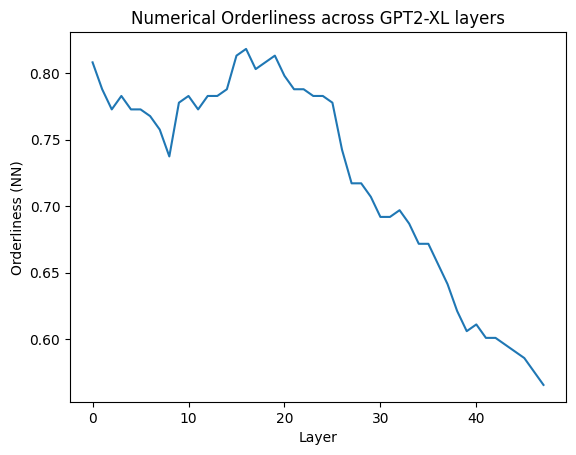

In [62]:
import matplotlib.pyplot as plt

plt.plot(orderness_per_layer)
plt.xlabel("Layer")
plt.ylabel("Orderliness (NN)")
plt.title("Numerical Orderliness across GPT2-XL layers")
plt.show()



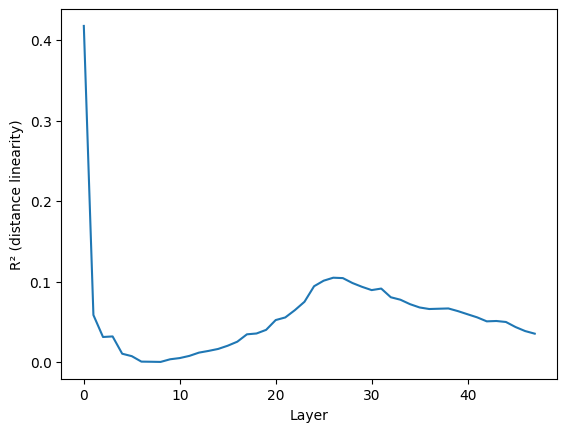

In [63]:
r2_scores = []

for layer in range(embeddings.shape[0]):
    embs = embeddings[layer].cpu().numpy()
    r2, k, b = distance_linear_analysis(embs, labels)
    r2_scores.append(r2)

plt.plot(r2_scores)
plt.xlabel("Layer")
plt.ylabel("R² (distance linearity)")
plt.show()


In [64]:
# lets check layer 15 pattern as it has the peak orderliness
layer15_pattern_from_cache = cache['pattern', 15]
q,k = cache['q', 15], cache['k', 15]
print(q.shape)
batch_size, seq, nhead, headsize = q.shape
layer15_attn_scores = einops.einsum(q,k, "b s_q n h, b s_k n h -> b n s_q s_k")
seq = q.shape[1]
mask = t.triu(t.ones((seq, seq), device=device, dtype=t.bool), diagonal=1)
layer15_attn_scores = layer15_attn_scores.masked_fill(mask,-1e9)
layer15_pattern_from_qk = (
    layer15_attn_scores / (headsize ** 0.5)
).softmax(dim=-1)
t.allclose(
    layer15_pattern_from_qk,
    layer15_pattern_from_cache,
    atol=1e-5
)



torch.Size([100, 2, 25, 64])


True

In [65]:
# focus only on number token attending to previous tokens
number_pos = 1
attn = layer15_pattern_from_cache[:, :, number_pos, :]
attn


tensor([[[0.7815, 0.2185],
         [0.6267, 0.3733],
         [0.9865, 0.0135],
         ...,
         [0.9729, 0.0271],
         [0.8833, 0.1167],
         [0.9305, 0.0695]],

        [[0.8715, 0.1285],
         [0.7201, 0.2799],
         [0.9703, 0.0297],
         ...,
         [0.8671, 0.1329],
         [0.9040, 0.0960],
         [0.7061, 0.2939]],

        [[0.8568, 0.1432],
         [0.7110, 0.2890],
         [0.9779, 0.0221],
         ...,
         [0.8274, 0.1726],
         [0.9115, 0.0885],
         [0.6506, 0.3494]],

        ...,

        [[0.9426, 0.0574],
         [0.6411, 0.3589],
         [0.9903, 0.0097],
         ...,
         [0.9332, 0.0668],
         [0.9188, 0.0812],
         [0.9363, 0.0637]],

        [[0.8877, 0.1123],
         [0.4398, 0.5602],
         [0.9911, 0.0089],
         ...,
         [0.9159, 0.0841],
         [0.8642, 0.1358],
         [0.8493, 0.1507]],

        [[0.8814, 0.1186],
         [0.5911, 0.4089],
         [0.9919, 0.0081],
         ...,
 

In [66]:
labels = list(range(1, 101))
number_pos = 1

head_orderness = {}

for layer in range(model.cfg.n_layers):
    head_orderness[layer] = {}
    for head in range(model.cfg.n_heads):
        z = cache["z", layer][:, number_pos, head, :]   # [batch, d_head]
        W_O = model.W_O[layer][head]                     # [d_head, d_model]
        head_embs = z @ W_O                              # [batch, d_model]

        score = nearest_neighbor_analysis(
            head_embs.cpu().numpy(),
            labels
        )

        head_orderness[layer][head] = score


### Code Logic Explanation:

1.  **`labels = list(range(1, 101))`**: This simply creates a list of numerical labels from 1 to 100, which corresponds to the numbers in your `numbers` input list (` '1'`, `' 2'`, ..., `' 100'`). These labels are used as the ground truth for evaluating orderliness.

2.  **`cache` Origin**: The `cache` object comes from the `logits, cache = model.run_with_cache(numbers, remove_batch_dim=False)` call you executed earlier. It stores all intermediate activations (like attention patterns, `q`, `k`, `v`, `z`, and residual streams) for every layer and head during the forward pass of the model.

3.  **Iterating through Layers and Heads**: The nested `for layer in range(model.cfg.n_layers):` and `for head in range(model.cfg.n_heads):` loops ensure that we examine the contribution of *every single attention head* in the model.

4.  **Extracting `z` (Attention Head Output)**:
    ```python
    z = cache["z", layer][:, number_pos, head, :]
    ```
    *   `cache["z", layer]` refers to the output of the attention mechanism *before* it's multiplied by the output weight matrix (`W_O`) for a specific layer. Its shape is typically `[batch, sequence_length, num_heads, d_head]`.
    *   `[:, number_pos, head, :]` extracts the `z` vector for all batches (`:`) at the `number_pos` (which is `1` for your single token numbers), for the current `head`, and all dimensions of the head's output (`:`).
    *   This `z` tensor represents the raw output vector of a single attention head for the specific token position across all input numbers.

5.  **Getting `W_O` (Output Weight Matrix)**:
    ```python
    W_O = model.W_O[layer][head]
    ```
    *   `model.W_O` is the output weight matrix of the attention blocks. Each head has its own `W_O` matrix that projects its output `z` from `d_head` dimensions back into the `d_model` (residual stream) dimensions.
    *   `[layer][head]` selects the specific `W_O` matrix for the current `layer` and `head`.

6.  **Calculating `head_embs` (Head's Contribution to Residual Stream)**:
    ```python
    head_embs = z @ W_O
    ```
    *   This performs a matrix multiplication of `z` (the attention head's raw output) with `W_O` (its output weight matrix).
    *   The result, `head_embs`, is a vector of shape `[batch, d_model]`. This vector effectively represents the specific contribution of *this single attention head* to the residual stream at the `number_pos` for each input number. By isolating this, we can assess what information this head adds to the overall representation of the number.

7.  **Calculating Orderliness Score**:
    ```python
    score = nearest_neighbor_analysis(head_embs.cpu().numpy(), labels)
    ```
    *   `head_embs.cpu().numpy()` moves the tensor to the CPU and converts it to a NumPy array, which is required by your `nearest_neighbor_analysis` function.
    *   The `nearest_neighbor_analysis` function then calculates how well the numerical sequence (1-100) is preserved *solely* based on the embeddings generated by this single attention head. A higher score means this head contributes more to maintaining the numerical order.

8.  **Storing Scores**:
    ```python
    head_orderness[layer][head] = score
    ```
    *   The calculated `score` for each `(layer, head)` pair is stored in a dictionary `head_orderness` for later analysis.

9.  **Ranking Heads**:
    ```python
    ranked = sorted(
        [(layer, head, score)
         for layer in head_orderness
         for head, score in head_orderness[layer].items()],
        key=lambda x: x[2],
        reverse=True
    )
    ```
    *   This code snippet flattens the `head_orderness` dictionary into a list of `(layer, head, score)` tuples.
    *   It then sorts this list in descending order (`reverse=True`) based on the `score` (the third element `x[2]` in each tuple).

10. **Printing Top Heads**: The final `for` loop prints the top 20 attention heads, showing their layer, head index, and the numerical orderliness score they achieved. This helps identify the most

numerically-aware

heads in the model.

In [67]:
ranked = sorted(
    [(layer, head, score)
     for layer in head_orderness
     for head, score in head_orderness[layer].items()],
    key=lambda x: x[2],
    reverse=True
)

for l, h, s in ranked[:20]:
    print(f"L{l}H{h}: {s:.3f}")



L14H19: 0.732
L14H16: 0.727
L18H15: 0.717
L21H23: 0.707
L25H24: 0.692
L23H22: 0.687
L31H2: 0.687
L21H15: 0.672
L13H8: 0.657
L26H14: 0.657
L9H18: 0.641
L2H7: 0.626
L11H20: 0.621
L3H5: 0.616
L9H16: 0.616
L15H17: 0.611
L4H15: 0.601
L8H12: 0.596
L6H4: 0.591
L12H13: 0.591


In [68]:
tokens = model.to_str_tokens(numbers)
layer = 15
attention_pattern = cache['pattern', layer] #[batch, heads, seq, seq]
heads = [19]
attention_subset = attention_pattern[:, heads, :, :]
import circuitsvis as cv
from IPython.display import display

display(
    cv.attention.attention_patterns(
        tokens=tokens,
        attention=attention_subset,
        attention_head_names=[f"L{layer}H{h}" for h in heads],
    )
)


In [69]:
def make_number_sequences(n=100): #changed n from 100 to 20 to avoid gpu issues for the patching experiment at the bottom
    """
    Generates sequences of consecutive numbers as strings.

    Args:
        n (int, optional): The upper limit for the starting number of sequences.
                           Defaults to 20, generating sequences up to '15 16 17 18 19'.

    Returns:
        list: A list of strings, where each string is a sequence of 5 consecutive numbers.
    """
    return [" ".join(str(i+j) for j in range(5)) for i in range(1, n-5)]
make_number_sequences()


['1 2 3 4 5',
 '2 3 4 5 6',
 '3 4 5 6 7',
 '4 5 6 7 8',
 '5 6 7 8 9',
 '6 7 8 9 10',
 '7 8 9 10 11',
 '8 9 10 11 12',
 '9 10 11 12 13',
 '10 11 12 13 14',
 '11 12 13 14 15',
 '12 13 14 15 16',
 '13 14 15 16 17',
 '14 15 16 17 18',
 '15 16 17 18 19',
 '16 17 18 19 20',
 '17 18 19 20 21',
 '18 19 20 21 22',
 '19 20 21 22 23',
 '20 21 22 23 24',
 '21 22 23 24 25',
 '22 23 24 25 26',
 '23 24 25 26 27',
 '24 25 26 27 28',
 '25 26 27 28 29',
 '26 27 28 29 30',
 '27 28 29 30 31',
 '28 29 30 31 32',
 '29 30 31 32 33',
 '30 31 32 33 34',
 '31 32 33 34 35',
 '32 33 34 35 36',
 '33 34 35 36 37',
 '34 35 36 37 38',
 '35 36 37 38 39',
 '36 37 38 39 40',
 '37 38 39 40 41',
 '38 39 40 41 42',
 '39 40 41 42 43',
 '40 41 42 43 44',
 '41 42 43 44 45',
 '42 43 44 45 46',
 '43 44 45 46 47',
 '44 45 46 47 48',
 '45 46 47 48 49',
 '46 47 48 49 50',
 '47 48 49 50 51',
 '48 49 50 51 52',
 '49 50 51 52 53',
 '50 51 52 53 54',
 '51 52 53 54 55',
 '52 53 54 55 56',
 '53 54 55 56 57',
 '54 55 56 57 58',
 '55 56 5

In [70]:
texts = make_number_sequences()
logits, cache = model.run_with_cache(texts, remove_batch_dim=False)
layer = 0
print(cache["pattern", layer].shape)



torch.Size([94, 25, 6, 6])


In [71]:
def adjacency_bias(cache, layer, head):
    """
    Calculates the 'adjacency bias' for a given attention head, which measures
    how much attention a token gives to its immediate numerical neighbors (previous and next) in a sequence.

    Args:
        cache (transformer_lens.ActivationCache): The activation cache from the model run.
        layer (int): The transformer layer index.
        head (int): The attention head index within the layer.

    Returns:
        float: The mean adjacency score across all sequences and relevant positions.
               Returns NaN if the sequence length is too short to calculate adjacency.
    """
    attn = cache["pattern", layer][:, head]  # [batch, seq, seq]
    seq = attn.shape[1]

    if seq < 4:
        return np.nan

    scores = []

    for b in range(attn.shape[0]):
        for pos in range(2, seq - 1):
            scores.append(
                (attn[b, pos, pos - 1] + attn[b, pos, pos + 1]).item()
            )

    return np.mean(scores)


all_adjacency_scores = []

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        score = adjacency_bias(cache, layer, head)
        all_adjacency_scores.append((layer, head, score))

# Sort the scores in descending order
all_adjacency_scores.sort(key=lambda x: -x[2])

print("Top 20 Heads by Adjacency Bias:")
for l, h, s in all_adjacency_scores[:20]:
    print(f"L{l}H{h}: {s:.3f}")


Top 20 Heads by Adjacency Bias:
L15H19: 0.995
L14H12: 0.976
L13H20: 0.955
L12H21: 0.947
L4H18: 0.906
L16H5: 0.833
L11H2: 0.829
L9H7: 0.725
L18H1: 0.677
L17H9: 0.655
L19H12: 0.616
L14H20: 0.585
L19H1: 0.574
L22H5: 0.559
L10H10: 0.489
L10H15: 0.473
L14H10: 0.468
L6H1: 0.460
L10H13: 0.450
L9H18: 0.450


In [72]:
top_adj_heads = all_adjacency_scores[:20]
adjacency_head_orderness = []

# Get the correct labels for the current batch size
# The batch size is determined by the 'texts' used to populate the cache in make_number_sequences()
# We can get this from any 'z' tensor in the cache.
current_batch_size = cache["z", top_adj_heads[0][0]].shape[0] # Get batch size from any head's z-output
local_labels = list(range(1, current_batch_size + 1))

for layer, head, adj_score in top_adj_heads:
    z = cache["z", layer][:, number_pos, head, :]   # [batch, d_head]
    W_O = model.W_O[layer][head]                     # [d_head, d_model]
    head_embs = z @ W_O                              # [batch, d_model]

    order_score = nearest_neighbor_analysis(
        head_embs.cpu().numpy(),
        local_labels # Use the dynamically created labels
    )

    adjacency_head_orderness.append(
        (layer, head, adj_score, order_score)
    )

In [73]:
adjacency_head_orderness

[(15, 19, 0.9954884606050262, 0.3172043010752688),
 (14, 12, 0.9760585346965925, 0.34408602150537637),
 (13, 20, 0.9546901393443981, 0.22043010752688172),
 (12, 21, 0.9471177522172319, 0.23118279569892472),
 (4, 18, 0.9055178965448488, 0.06989247311827956),
 (16, 5, 0.8326730796842711, 0.45698924731182794),
 (11, 2, 0.8294167181490161, 0.27956989247311825),
 (9, 7, 0.7246328928369157, 0.21505376344086022),
 (18, 1, 0.6772429119557777, 0.3279569892473118),
 (17, 9, 0.6548704870098027, 0.3817204301075269),
 (19, 12, 0.6157784352065824, 0.41397849462365593),
 (14, 20, 0.5851425342525997, 0.5698924731182796),
 (19, 1, 0.5737677896461377, 0.21505376344086022),
 (22, 5, 0.558684928501223, 0.43010752688172044),
 (10, 10, 0.4892972669174485, 0.3978494623655914),
 (10, 15, 0.4728960723001906, 0.489247311827957),
 (14, 10, 0.4683026415130771, 0.3763440860215054),
 (6, 1, 0.46038376381422613, 0.42473118279569894),
 (10, 13, 0.45022455185440413, 0.24193548387096775),
 (9, 18, 0.4499884705911291, 0

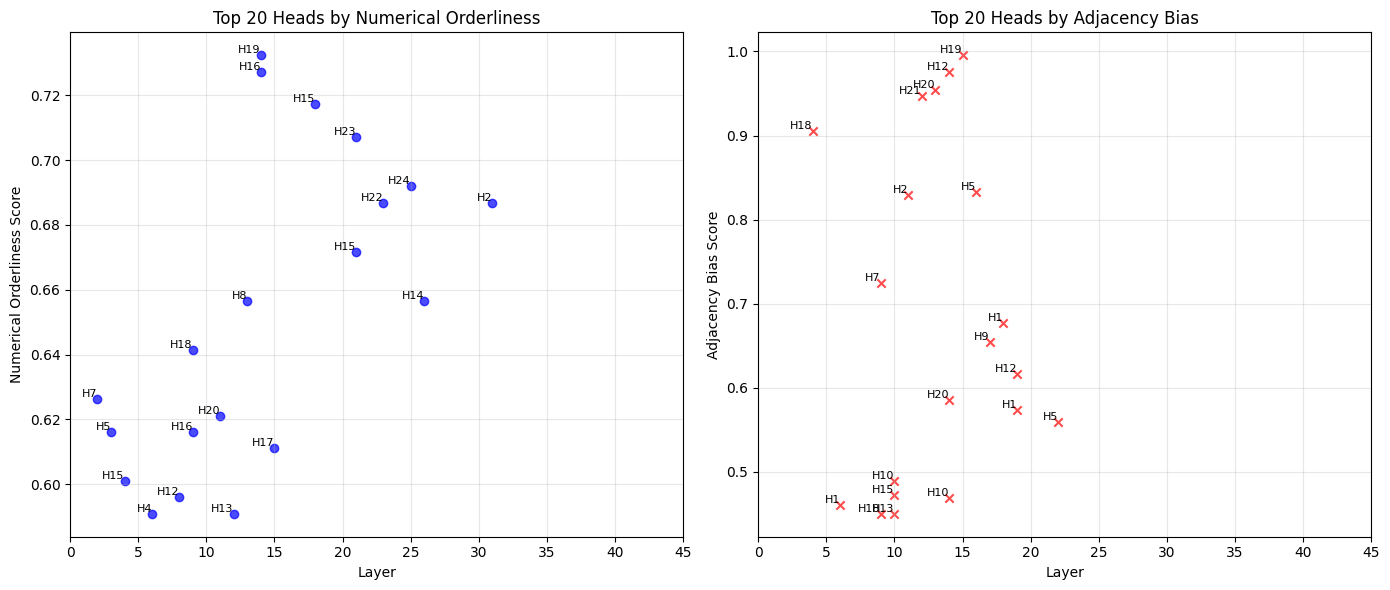

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Extract top 20 orderliness heads from the 'ranked' list
top_orderness_heads = ranked[:20]
orderness_layers = [item[0] for item in top_orderness_heads]
orderness_scores = [item[2] for item in top_orderness_heads]
orderness_head_indices = [item[1] for item in top_orderness_heads]

# Extract top 20 adjacency bias heads from the 'all_adjacency_scores' list
# (Note: all_adjacency_scores is already sorted by score)
top_adjacency_heads = all_adjacency_scores[:20]
adjacency_layers = [item[0] for item in top_adjacency_heads]
adjacency_scores = [item[2] for item in top_adjacency_heads]
adjacency_head_indices = [item[1] for item in top_adjacency_heads]

plt.figure(figsize=(14, 6))

# Plot for Top Orderliness Heads
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.scatter(orderness_layers, orderness_scores, marker='o', color='blue', alpha=0.7)
for i, (l, s, h_idx) in enumerate(zip(orderness_layers, orderness_scores, orderness_head_indices)):
    plt.text(l, s, f'H{h_idx}', fontsize=8, ha='right', va='bottom') # Add head index label
plt.xlabel("Layer")
plt.ylabel("Numerical Orderliness Score")
plt.title("Top 20 Heads by Numerical Orderliness")
plt.xticks(np.arange(0, model.cfg.n_layers, 5)) # Set x-ticks to every 5 layers for readability
plt.grid(True, alpha=0.3)

# Plot for Top Adjacency Bias Heads
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.scatter(adjacency_layers, adjacency_scores, marker='x', color='red', alpha=0.7)
for i, (l, s, h_idx) in enumerate(zip(adjacency_layers, adjacency_scores, adjacency_head_indices)):
    plt.text(l, s, f'H{h_idx}', fontsize=8, ha='right', va='bottom') # Add head index label
plt.xlabel("Layer")
plt.ylabel("Adjacency Bias Score")
plt.title("Top 20 Heads by Adjacency Bias")
plt.xticks(np.arange(0, model.cfg.n_layers, 5)) # Set x-ticks to every 5 layers for readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

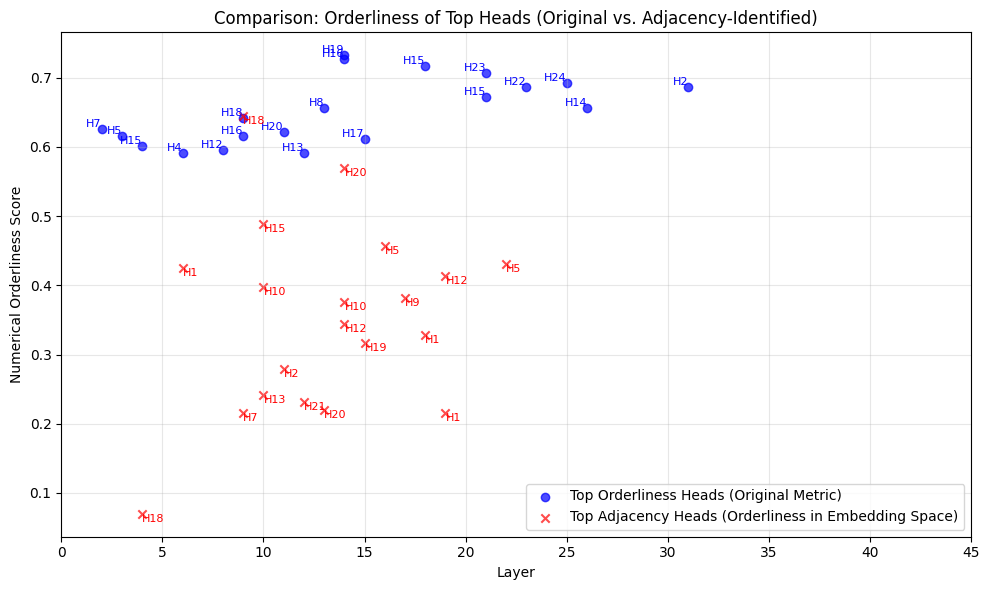

In [75]:
# Calculate orderliness for heads identified by high adjacency bias
adj_heads_orderness_scores = []
adj_heads_layers = []
adj_heads_indices = []

# Get the correct labels for the current batch size (from 'texts' which was used to populate 'cache')
current_batch_size = cache["z", top_adjacency_heads[0][0]].shape[0] # Get batch size from any head's z-output
local_labels = list(range(1, current_batch_size + 1))

# top_adjacency_heads is already sorted by adjacency bias score
for l, h, _ in top_adjacency_heads:
    z = cache["z", l][:, number_pos, h, :]   # [batch, d_head]
    W_O = model.W_O[l][h]                     # [d_head, d_model]
    head_embs = z @ W_O                      # [batch, d_model]

    score = nearest_neighbor_analysis(
        head_embs.cpu().numpy(),
        local_labels # Use the dynamically created labels
    )

    adj_heads_orderness_scores.append(score)
    adj_heads_layers.append(l)
    adj_heads_indices.append(h)


plt.figure(figsize=(10, 6))

plt.scatter(
    orderness_layers,
    orderness_scores,
    marker='o',
    color='blue',
    alpha=0.7,
    label='Top Orderliness Heads (Original Metric)'
)

for i, (l, s, h_idx) in enumerate(zip(orderness_layers, orderness_scores, orderness_head_indices)):
    plt.text(l, s, f'H{h_idx}', fontsize=8, ha='right', va='bottom', color='blue')

plt.scatter(
    adj_heads_layers,
    adj_heads_orderness_scores,
    marker='x',
    color='red',
    alpha=0.7,
    label='Top Adjacency Heads (Orderliness in Embedding Space)'
)

for i, (l, s, h_idx) in enumerate(zip(adj_heads_layers, adj_heads_orderness_scores, adj_heads_indices)):
    plt.text(l, s, f'H{h_idx}', fontsize=8, ha='left', va='top', color='red')

plt.xlabel("Layer")
plt.ylabel("Numerical Orderliness Score")
plt.title("Comparison: Orderliness of Top Heads (Original vs. Adjacency-Identified)")
plt.xticks(np.arange(0, model.cfg.n_layers, 5))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ahh hmm above its kinda impractical to visualize the heads as its too big to display

so how bout if we try to see the adjacency bias like when processing number n how much attention mass goes to n-1 and n+1

In [ ]:
def adjacency_bias(cache, layer, head, number_pos=1):
    """
    Calculates a specific 'adjacency bias' for single number tokens,
    measuring attention given to the BOS token and the token itself.
    Note: This definition of adjacency bias is for a specific, simplified scenario
    where `number_pos` is 1 and considers attention to BOS (index 0) and self (index 1).

    Args:
        cache (transformer_lens.ActivationCache): The activation cache from the model run.
        layer (int): The transformer layer index.
        head (int): The attention head index within the layer.
        number_pos (int, optional): The position of the number token. Defaults to 1.

    Returns:
        float: The mean of (attention to BOS + attention to self) across batches.
    """
    attn = cache["pattern", layer]          # [batch, heads, seq, seq]
    attn = attn[:, head, number_pos, :]     # [batch, seq]

    # positions: 0 = BOS, 1 = number
    # adjacency in *batch index space*
    adj_scores = []

    for i in range(1, attn.shape[0] - 1):
        left = attn[i, 0]   # BOS (proxy for n-1 in isolated setting)
        right = attn[i, 1]  # self
        adj_scores.append(left + right)

    return np.mean(adj_scores)
head_scores = []

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        score = adjacency_bias(cache, layer, head)
        head_scores.append((layer, head, score))

head_scores.sort(key=lambda x: -x[2])
head_scores[:20]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [76]:
def make_number_sequences(n=100):
    """
    Generates sequences of consecutive numbers as strings.

    Args:
        n (int, optional): The upper limit for the starting number of sequences.
                           Defaults to 100, generating sequences up to '95 96 97 98 99'.

    Returns:
        list: A list of strings, where each string is a sequence of 5 consecutive numbers.
    """
    return [" ".join(str(i+j) for j in range(5)) for i in range(1, n-5)]

texts = make_number_sequences()
logits, cache = model.run_with_cache(texts)
tokens = model.to_str_tokens(texts)
def adjacency_bias(cache, layer, head):
    """
    Calculates the 'adjacency bias' for a given attention head, measuring
    how much attention a token gives to its immediate numerical neighbors (previous and next) in a sequence.

    Args:
        cache (transformer_lens.ActivationCache): The activation cache from the model run.
        layer (int): The transformer layer index.
        head (int): The attention head index within the layer.

    Returns:
        float: The mean adjacency score across all sequences and relevant positions.
    """
    attn = cache["pattern", layer]   # [batch, heads, seq, seq]
    attn = attn[:, head]             # [batch, seq, seq]

    scores = []

    for b in range(attn.shape[0]):
        for pos in range(2, attn.shape[1] - 1):  # skip BOS
            left = attn[b, pos, pos-1]
            right = attn[b, pos, pos+1]
            scores.append(left + right)

    return np.mean(scores)



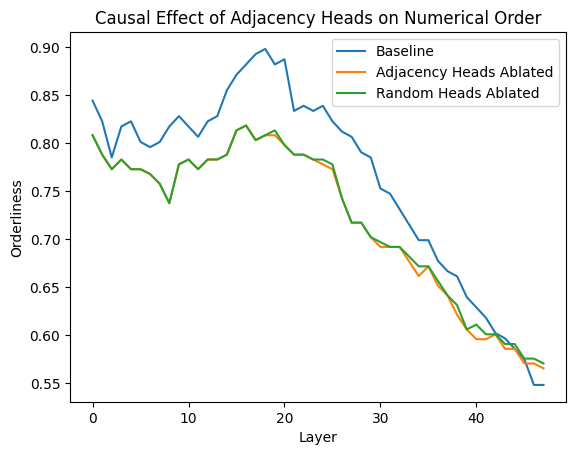

In [77]:
import random
top_adj_heads = {
    14: [19],
    13: [20],
    12: [21],
    15: [19],
}

from functools import partial

patched_cache = {}

def cache_and_ablate_z(z, hook, heads_to_ablate):
    """
    A forward hook function to cache activations (z) and then ablate specific heads
    by setting their activations to zero.

    Args:
        z (torch.Tensor): The activations tensor for attention heads.
        hook (transformer_lens.hook_points.HookPoint): The hook point object.
        heads_to_ablate (list): A list of head indices to ablate.

    Returns:
        torch.Tensor: The modified activations tensor with specified heads ablated.
    """
    # store activation
    patched_cache[hook.name] = z.detach()

    # ablate
    z = z.clone()
    z[:, :, heads_to_ablate, :] = 0.0
    return z


def cache_resid_post(resid, hook):
    """
    A forward hook function to cache the residual stream after a block.

    Args:
        resid (torch.Tensor): The residual stream tensor.
        hook (transformer_lens.hook_points.HookPoint): The hook point object.

    Returns:
        torch.Tensor: The unmodified residual stream tensor.
    """
    patched_cache[hook.name] = resid.detach()
    return resid

def run_head_ablation(model, texts, heads_by_layer):
    """
    Runs the model with ablation hooks to zero out activations of specified attention heads.
    Caches both ablated `z` and `resid_post` activations.

    Args:
        model (transformer_lens.HookedTransformer): The transformer model.
        texts (list): A list of input texts.
        heads_by_layer (dict): A dictionary where keys are layer indices and values are
                               lists of head indices to ablate in that layer.

    Returns:
        dict: The `patched_cache` containing stored activations.
    """
    patched_cache.clear()
    fwd_hooks = []

    for layer, heads in heads_by_layer.items():
        hook_name = f"blocks.{layer}.attn.hook_z"
        fwd_hooks.append(
            (hook_name, partial(cache_and_ablate_z, heads_to_ablate=heads))
        )
    for layer in range(model.cfg.n_layers):
      fwd_hooks.append(
          (f"blocks.{layer}.hook_resid_post", cache_resid_post)
      )

    model.run_with_hooks(
        texts,
        return_type=None,
        fwd_hooks=fwd_hooks
    )

    return patched_cache



def compute_orderness_from_cache(cache, model, number_pos=1):
    """
    Computes the numerical orderliness score for each layer's residual stream
    embeddings from a given activation cache (e.g., baseline).

    Args:
        cache (transformer_lens.ActivationCache): The activation cache.
        model (transformer_lens.HookedTransformer): The transformer model.
        number_pos (int, optional): The position of the number token in the sequence.
                                    Defaults to 1.

    Returns:
        np.ndarray: An array of orderliness scores, one for each layer.
    """
    batch_size = cache["resid_post", 0].shape[0]
    labels = list(range(1, batch_size + 1))  # ❅ FIX

    embeddings = []
    for layer in range(model.cfg.n_layers):
        emb = cache["resid_post", layer][:, number_pos, :]
        embeddings.append(emb.cpu())

    embeddings = t.stack(embeddings)

    orderness = []
    for layer in range(embeddings.shape[0]):
        score = nearest_neighbor_analysis(
            embeddings[layer].numpy(),
            labels
        )
        orderness.append(score)

    return np.array(orderness)
def compute_orderness_from_patched_cache(patched_cache, model, number_pos=1):
    """
    Computes the numerical orderliness score for each layer's residual stream
    embeddings from a patched activation cache (e.g., after ablation).

    Args:
        patched_cache (dict): A dictionary of patched activations, typically from `run_head_ablation`.
        model (transformer_lens.HookedTransformer): The transformer model.
        number_pos (int, optional): The position of the number token in the sequence.
                                    Defaults to 1.

    Returns:
        np.ndarray: An array of orderliness scores, one for each layer.
    """
    layers = model.cfg.n_layers
    batch_size = list(patched_cache.values())[0].shape[0]
    labels = list(range(1, batch_size + 1))

    orderness = []

    for layer in range(layers):
        key = f"blocks.{layer}.hook_resid_post"
        emb = patched_cache[key][:, number_pos, :].cpu().numpy()
        score = nearest_neighbor_analysis(emb, labels)
        orderness.append(score)

    return np.array(orderness)
baseline_orderness = compute_orderness_from_cache(cache, model)

adj_cache = run_head_ablation(model, numbers, top_adj_heads)
adj_orderness = compute_orderness_from_patched_cache(adj_cache, model)

random_heads = {
    layer: random.sample(range(model.cfg.n_heads), 1)
    for layer in top_adj_heads
}

rand_cache = run_head_ablation(model, numbers, random_heads)
rand_orderness = compute_orderness_from_patched_cache(rand_cache, model)

plt.plot(baseline_orderness, label="Baseline")
plt.plot(adj_orderness, label="Adjacency Heads Ablated")
plt.plot(rand_orderness, label="Random Heads Ablated")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Orderliness")
plt.title("Causal Effect of Adjacency Heads on Numerical Order")
plt.show()



In [78]:
clean_numbers = make_number_sequences()
import random

def corrupt_sequences(texts):
    """
    Corrupts a list of text sequences by randomly shuffling the tokens within each sequence.

    Args:
        texts (list): A list of string sequences.

    Returns:
        list: A new list of corrupted string sequences.
    """
    corrupted = []
    for t in texts:
        toks = t.split()
        random.shuffle(toks)
        corrupted.append(" ".join(toks))
    return corrupted

corrupted_numbers = corrupt_sequences(clean_numbers)
corrupted_numbers[:5]


['5 3 2 1 4', '3 4 6 2 5', '7 5 4 6 3', '6 5 4 7 8', '8 7 6 5 9']

In [79]:
clean_numbers[:5]


['1 2 3 4 5', '2 3 4 5 6', '3 4 5 6 7', '4 5 6 7 8', '5 6 7 8 9']

In [80]:
t.cuda.empty_cache()


In [81]:

model.eval()
t.set_grad_enabled(False)


torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [82]:
clean_resid_by_layer = {}

for layer in range(model.cfg.n_layers):
    _, cache = model.run_with_cache(
        clean_numbers,
        return_type=None,
        remove_batch_dim=False,
        names_filter=lambda name: name == f"blocks.{layer}.hook_resid_post"
    )

    clean_resid_by_layer[layer] = cache["resid_post", layer].cpu()

    del cache
    t.cuda.empty_cache()


In [83]:
clean_orderness = []

for layer in range(model.cfg.n_layers):
    emb = clean_resid_by_layer[layer][:, 1, :].numpy()
    labels = list(range(1, emb.shape[0] + 1))

    clean_orderness.append(
        nearest_neighbor_analysis(emb, labels)
    )


In [84]:
corrupted_orderness = []

for layer in range(model.cfg.n_layers):
    _, cache = model.run_with_cache(
        corrupted_numbers,
        return_type=None,
        remove_batch_dim=False,
        names_filter=lambda name: name == f"blocks.{layer}.hook_resid_post"
    )

    emb = cache["resid_post", layer][:, 1, :].cpu().numpy()
    labels = list(range(1, emb.shape[0] + 1))

    corrupted_orderness.append(
        nearest_neighbor_analysis(emb, labels)
    )

    del cache
    t.cuda.empty_cache()


In [85]:
from functools import partial

def patch_resid_post(act, hook, clean_act):
    return clean_act.to(act.device)


In [86]:
patched_resid = {}
def patch_and_save_resid(act, hook, layer, clean_act):
    patched = clean_act.to(act.device)
    patched_resid[layer] = patched.detach().cpu()
    return patched


In [87]:
patched_orderness = []

for layer in range(model.cfg.n_layers):
    patched_resid.clear()

    model.run_with_hooks(
        corrupted_numbers,
        return_type=None,
        fwd_hooks=[
            (
                f"blocks.{layer}.hook_resid_post",
                partial(
                    patch_and_save_resid,
                    layer=layer,
                    clean_act=clean_resid_by_layer[layer]
                )
            )
        ]
    )

    emb = patched_resid[layer][:, 1, :].numpy()
    labels = list(range(1, emb.shape[0] + 1))

    patched_orderness.append(
        nearest_neighbor_analysis(emb, labels)
    )

    t.cuda.empty_cache()


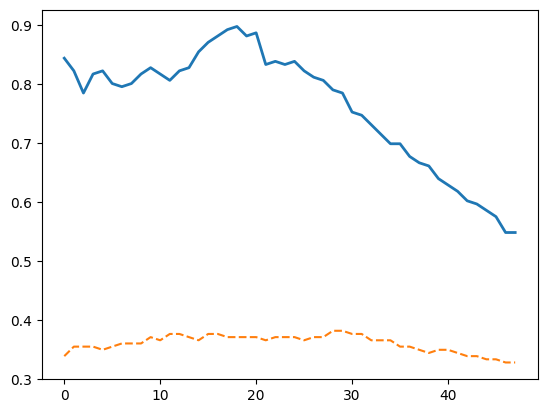

In [88]:
plt.plot(baseline_orderness, label="Clean", linewidth=2)
plt.plot(corrupted_orderness, label="Corrupted", linestyle="--")


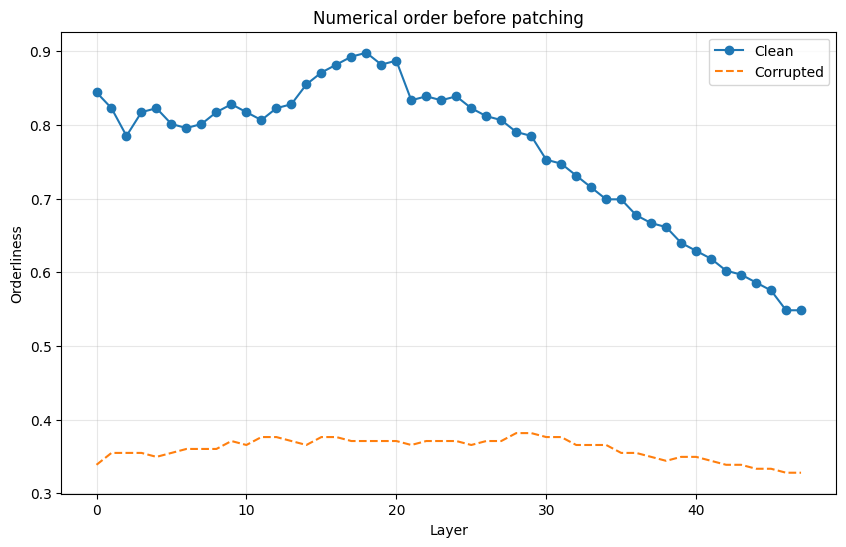

In [97]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

plt.plot(baseline_orderness, label="Clean", marker="o")
plt.plot(corrupted_orderness, label="Corrupted", linestyle="--")


plt.xlabel("Layer")
plt.ylabel("Orderliness")
plt.title("Numerical order before patching")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


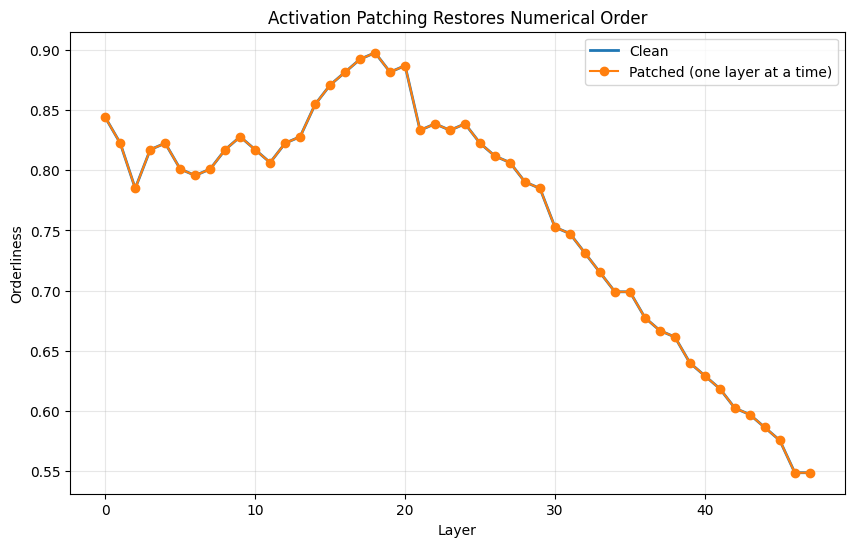

In [90]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

plt.plot(baseline_orderness, label="Clean", linewidth=2)

plt.plot(
    patched_orderness,
    label="Patched (one layer at a time)",
    marker="o"
)

plt.xlabel("Layer")
plt.ylabel("Orderliness")
plt.title("Activation Patching Restores Numerical Order")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


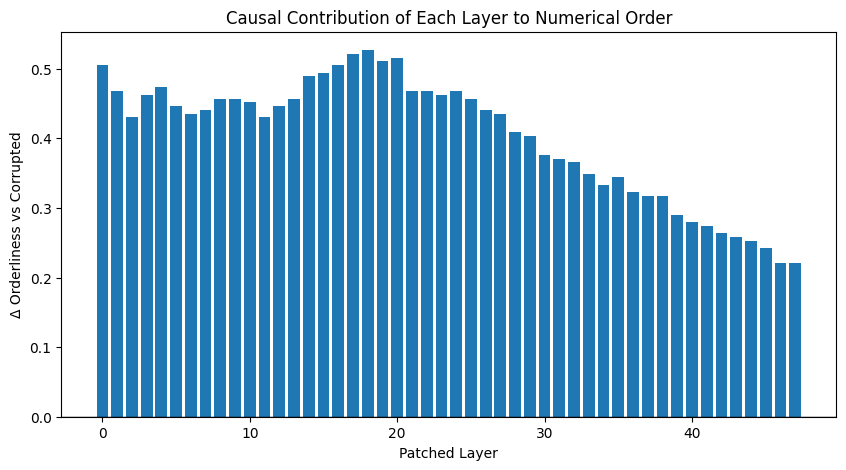

In [91]:
delta = np.array(patched_orderness) - np.array(corrupted_orderness)

plt.figure(figsize=(10, 5))
plt.bar(range(len(delta)), delta)
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Patched Layer")
plt.ylabel("Δ Orderliness vs Corrupted")
plt.title("Causal Contribution of Each Layer to Numerical Order")

plt.show()


In [92]:
print(
    "Max recovery at layer:",
    np.argmax(delta),
    "Δ =", delta.max()
)


Max recovery at layer: 18 Δ = 0.5268817204301075


In [1]:
# caching clean source peak layer(18th layer)

SOURCE_LAYER = 18

# cache clean resid
_, clean_cache = model.run_with_cache(
    clean_numbers,
    return_type=None,
    remove_batch_dim=False,
    names_filter = lambda n: n == f"blocks.{SOURCE_LAYER}.hook_resid_post"
)

clean_source_resid = clean_cache["resid_post", SOURCE_LAYER].cpu()
del clean_cache
t.cuda.empty_cache()

NameError: name 'model' is not defined

In [94]:
# defining patch hook
from functools import partial
def transplant_resid(act, hook, clean_resid):
  return clean_resid.to(act.device)

In [95]:
# patching that into the late layers
target_layers = list(range(model.cfg.n_layers - 10, model.cfg.n_layers))
recovered_orderness = []

for L in target_layers:
  print(f"patching into layer {L}")
  measure_layer = model.cfg.n_layers - 1
  patched_resid = {}

  def save_resid(act, hook):
    patched_resid["final"] = act.detach().cpu()
    return act

  model.run_with_hooks(
      corrupted_numbers,
      return_type = None,
      fwd_hooks=[
          (f"blocks.{L}.hook_resid_post",
           partial(transplant_resid, clean_resid=clean_source_resid)),
          (f"blocks.{measure_layer}.hook_resid_post", save_resid)
      ]
  )


  emb = patched_resid["final"][:,1,:].numpy()
  labels = list(range(1, emb.shape[0] + 1))
  score = nearest_neighbor_analysis(emb, labels)
  recovered_orderness.append(score)
  t.cuda.empty_cache()

patching into layer 38
patching into layer 39
patching into layer 40
patching into layer 41
patching into layer 42
patching into layer 43
patching into layer 44
patching into layer 45
patching into layer 46
patching into layer 47


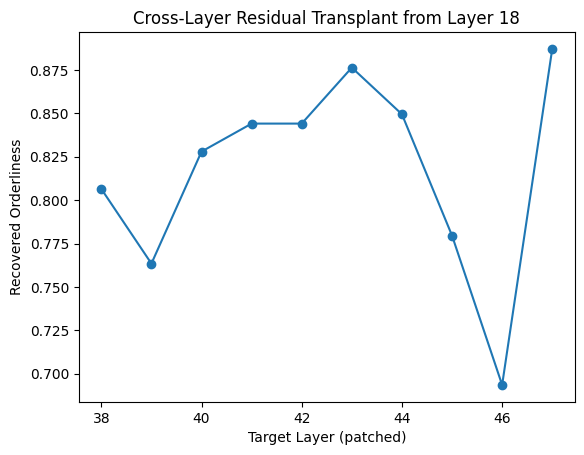

In [96]:
import matplotlib.pyplot as plt

plt.plot(target_layers, recovered_orderness, marker="o")
plt.xlabel("Target Layer (patched)")
plt.ylabel("Recovered Orderliness")
plt.title("Cross-Layer Residual Transplant from Layer 18")
plt.show()


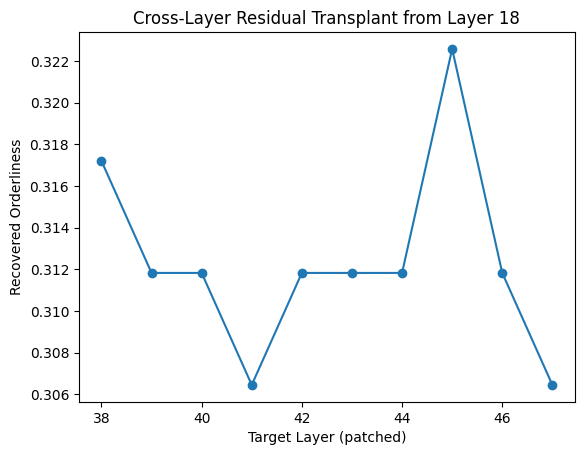

In [ ]:
SOURCE_LAYER = 20

_, clean_cache = model.run_with_cache(
    clean_numbers,
    return_type=None,
    names_filter=lambda n: n == f"blocks.{SOURCE_LAYER}.hook_mlp_out"
)

clean_mlp_out = clean_cache["mlp_out", SOURCE_LAYER].cpu()

del clean_cache
t.cuda.empty_cache()


def transplant_mlp(act, hook, clean_mlp):
    return clean_mlp.to(act.device)

target_layers = list(range(model.cfg.n_layers - 10, model.cfg.n_layers))
recovered_orderness = []

for L in target_layers:

    measure_layer = model.cfg.n_layers - 1
    patched_resid = {}

    def save_resid(act, hook):
        patched_resid["final"] = act.detach().cpu()
        return act

    model.run_with_hooks(
        corrupted_numbers,
        return_type=None,
        fwd_hooks=[
            (f"blocks.{L}.hook_mlp_out",
             partial(transplant_mlp, clean_mlp=clean_mlp_out)),
            (f"blocks.{measure_layer}.hook_resid_post", save_resid)
        ]
    )

    emb = patched_resid["final"][:,1,:].numpy()
    labels = list(range(1, emb.shape[0] + 1))
    score = nearest_neighbor_analysis(emb, labels)

    recovered_orderness.append(score)
    t.cuda.empty_cache()

import matplotlib.pyplot as plt

plt.plot(target_layers, recovered_orderness, marker="o")
plt.xlabel("Target Layer (patched)")
plt.ylabel("Recovered Orderliness")
plt.title("Cross-Layer Residual Transplant from Layer 18")
plt.show()


Caching clean attention output from layer 20
Patching attention into layer 38
Patching attention into layer 39
Patching attention into layer 40
Patching attention into layer 41
Patching attention into layer 42
Patching attention into layer 43
Patching attention into layer 44
Patching attention into layer 45
Patching attention into layer 46
Patching attention into layer 47


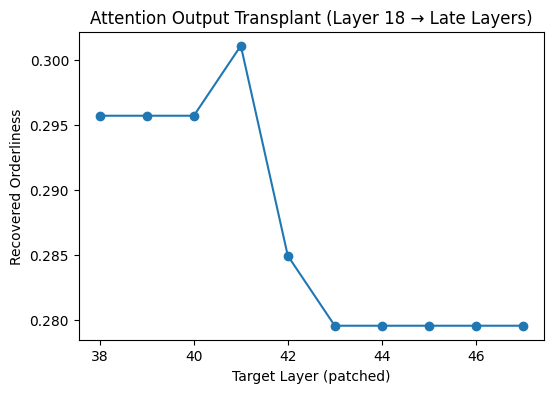

In [ ]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

########################################
# CONFIG
########################################

SOURCE_LAYER = 20
TARGET_LAYERS = list(range(model.cfg.n_layers - 10, model.cfg.n_layers))
NUMBER_POS = 1  # token position where numbers live


########################################
# 1) CACHE CLEAN ATTENTION OUTPUT
########################################

print(f"Caching clean attention output from layer {SOURCE_LAYER}")

_, clean_cache = model.run_with_cache(
    clean_numbers,
    return_type=None,
    remove_batch_dim=False,
    names_filter=lambda n: n == f"blocks.{SOURCE_LAYER}.hook_attn_out"
)

clean_attn_out = clean_cache["attn_out", SOURCE_LAYER].detach().cpu()

del clean_cache
t.cuda.empty_cache()


########################################
# 2) DEFINE TRANSPLANT HOOK
########################################

def transplant_attn(act, hook, clean_attn):
    # overwrite corrupted activation with clean one
    return clean_attn.to(act.device)


########################################
# 3) RUN TRANSPLANT EXPERIMENT
########################################

recovered_orderness = []

for L in TARGET_LAYERS:

    print(f"Patching attention into layer {L}")

    patched_resid = {}

    # Save final-layer residual stream
    def save_final_resid(act, hook):
        patched_resid["final"] = act.detach().cpu()
        return act

    measure_layer = model.cfg.n_layers - 1

    model.run_with_hooks(
        corrupted_numbers,
        return_type=None,
        fwd_hooks=[
            (
                f"blocks.{L}.hook_attn_out",
                partial(transplant_attn, clean_attn=clean_attn_out)
            ),
            (
                f"blocks.{measure_layer}.hook_resid_post",
                save_final_resid
            )
        ]
    )

    ########################################
    # 4) COMPUTE ORDERLINESS
    ########################################

    emb = patched_resid["final"][:, NUMBER_POS, :].numpy()

    labels = list(range(1, emb.shape[0] + 1))

    score = nearest_neighbor_analysis(emb, labels)

    recovered_orderness.append(score)

    t.cuda.empty_cache()


########################################
# 5) PLOT
########################################

plt.figure(figsize=(6,4))
plt.plot(TARGET_LAYERS, recovered_orderness, marker="o")
plt.xlabel("Target Layer (patched)")
plt.ylabel("Recovered Orderliness")
plt.title("Attention Output Transplant (Layer 18 → Late Layers)")
plt.show()


In [ ]:
SOURCE_LAYER = 20

_, corr_cache = model.run_with_cache(
    corrupted_numbers,
    return_type=None,
    remove_batch_dim=False,
    names_filter=lambda n: n == f"blocks.{SOURCE_LAYER}.hook_resid_post"
)

corr_resid18 = corr_cache["resid_post", SOURCE_LAYER].cpu()

del corr_cache
t.cuda.empty_cache()

from functools import partial

def destructive_patch(act, hook, corr_resid):
    return corr_resid.to(act.device)

measure_layer = model.cfg.n_layers - 1

patched_resid = {}

def save_final(act, hook):
    patched_resid["final"] = act.detach().cpu()
    return act

model.run_with_hooks(
    clean_numbers,
    return_type=None,
    fwd_hooks=[
        (f"blocks.{SOURCE_LAYER}.hook_resid_post",
         partial(destructive_patch, corr_resid=corr_resid18)),

        (f"blocks.{measure_layer}.hook_resid_post",
         save_final)
    ]
)

emb = patched_resid["final"][:, 1, :].numpy()
labels = list(range(1, emb.shape[0] + 1))

destruction_score = nearest_neighbor_analysis(emb, labels)

print("Orderliness after destruction:", destruction_score)


Orderliness after destruction: 0.22580645161290322


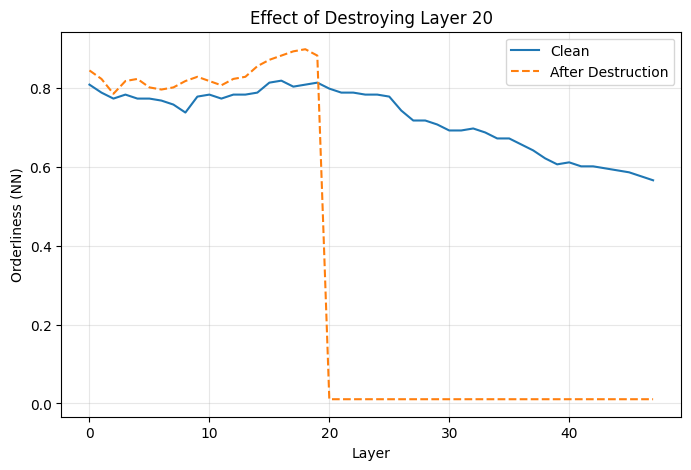

In [ ]:
DESTRUCTION_LAYER = 20

def destroy_resid(act, hook):
    return t.zeros_like(act)


model.add_hook(
    f"blocks.{DESTRUCTION_LAYER}.hook_resid_post",
    destroy_resid
)

_, destroyed_cache = model.run_with_cache(
    clean_numbers,
    remove_batch_dim=False
)

model.reset_hooks()

destroyed_orderness = []

for layer in range(num_layers):
    emb = destroyed_cache['resid_post', layer][:, number_pos, :]
    score = nearest_neighbor_analysis(
        emb.cpu().numpy(),
        labels
    )
    destroyed_orderness.append(score)

destroyed_orderness = np.array(destroyed_orderness)

plt.figure(figsize=(8,5))

plt.plot(orderness_per_layer, label="Clean")
plt.plot(destroyed_orderness, label="After Destruction", linestyle="--")

plt.xlabel("Layer")
plt.ylabel("Orderliness (NN)")
plt.title(f"Effect of Destroying Layer {DESTRUCTION_LAYER}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

